<a href="https://colab.research.google.com/github/SaiSoundharya/Next-word-prediction/blob/main/next_word_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import numpy as np
import tensorflow as tf
from numpy.core.multiarray import dtype
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
np.random.seed(42)
tf.random.set_seed(42)
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

# Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/dataset.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


# Data preprocessing

In [ ]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print ("unique chars: ",len(chars))

unique chars:  73


# Feature engineering

In [ ]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i:i+SEQUENCE_LENGTH])
    next_chars.append(text[i+SEQUENCE_LENGTH])
print('num training examples: ',len(sentences))

num training examples:  193950


In [ ]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# Building the Recurrent Neural network

In [ ]:
model = Sequential();
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112,841
Trainable params: 112,841
Non-trainable params: 0
_________________________________________________________________


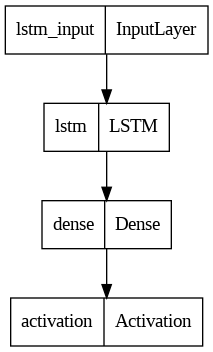

In [ ]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

# Training the Next Word Prediction Model

In [ ]:
optimizer = RMSprop(learning_rate= 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=30, shuffle=True).history

Epoch 1/30
1440/1440 [==============================] - 182s 122ms/step - loss: 1.9661 - accuracy: 0.4227 - val_loss: 2.1046 - val_accuracy: 0.4220
Epoch 2/30
1440/1440 [==============================] - 170s 118ms/step - loss: 1.6206 - accuracy: 0.5141 - val_loss: 2.0739 - val_accuracy: 0.4247
Epoch 3/30
1440/1440 [==============================] - 171s 119ms/step - loss: 1.5184 - accuracy: 0.5404 - val_loss: 2.0516 - val_accuracy: 0.4467
Epoch 4/30
1440/1440 [==============================] - 170s 118ms/step - loss: 1.4639 - accuracy: 0.5543 - val_loss: 2.0375 - val_accuracy: 0.4559
Epoch 5/30
1440/1440 [==============================] - 171s 119ms/step - loss: 1.4260 - accuracy: 0.5640 - val_loss: 2.0314 - val_accuracy: 0.4568
Epoch 6/30
1440/1440 [==============================] - 171s 119ms/step - loss: 1.4005 - accuracy: 0.5715 - val_loss: 2.0251 - val_accuracy: 0.4659
Epoch 7/30
1440/1440 [==============================] - 171s 119ms/step - loss: 1.3803 - accuracy: 0.5769 - val_

In [ ]:
# model.save('next_word_model.h5')
# pickle.dump(history, open("history.p", "wb"))
# model = load_model('next_word_model.h5')
# history = pickle.load(open("history.p", "rb"))

from keras.models import load_model
MODELPATH = '/content/gdrive/MyDrive/next_words2.h5'
model.save(MODELPATH)
model = load_model(MODELPATH)
pickle.dump(history, open("/content/gdrive/MyDrive/history.p", "wb"))
# history = pickle.load(open("history.p", "rb"))

In [ ]:
from keras.models import load_model
MODELPATH = '/content/gdrive/MyDrive/next_words2.h5'
model = load_model(MODELPATH)

# Evaluating the Model

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("01.Accuracy.png")

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("02.Loss.png")

# Testing the Model

In [ ]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1
    return x

In [ ]:
#The sample function
#This function allows us to ask our model what are the next probable characters (The heap simplifies the job)
def sample(preds, top_n = 3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
#Prediction function
def predict_completion(text):
    original_text = text
    generalised = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char

        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [ ]:
#This methods wraps everything and allows us to predict multiple completions
def predict_completions(text, n = 3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [ ]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [ ]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'a ', 'his ', 'man ', 'bring ']

that which does not kill us makes us str
['eet. ', 'uck ', 'ikes ', 'ong ', 'ange ']

i'm not upset that you lied to me, i'm u
['nderstand, ', 'pon ', 'sed ', 'tterly ', '\nwas ']

and those who were seen dancing were tho
['ugh ', 'se ', 't ', 'refather ', ' clear ']

it is hard enough to remember my opinion
[' in ', 's ', '. ', ', ', '\nthe ']



In [ ]:
while(True):
  text = input("Enter your line: ")

  if text == "0":
      print("Execution completed...")
      break

  else:
      seq = text[:40].lower()
      print(seq)
      print(predict_completions(seq, 5))
      print()


the august person who employs me wishes 
['and ', 'the ', 'with ', 'between ', 'of ']

the august person who employs me wishes
['fsbbbsbcmpbbsbbbsbm\nbfbid-bbcmsm. ', 'bbbsbb ', 'mbbbskswbtlbbbbim’s.bcbswbbbsmbbcesmsm-bbb ', 'sf-bbsbbbsbb ', 'cbbbsub-bbbbcmbbbqbcm’a-lbb-bbsbsbbbybbsbbb ']

the august person who employs me wishes 
['and ', 'the ', 'with ', 'between ', 'of ']

